In [1]:
cd /Users/quinnunderriner/Desktop/Work/missing_middle/zillow

/Users/quinnunderriner/Desktop/Work/missing_middle/zillow


In [2]:
import numpy as np
import pandas as pd
import zipfile         
import os
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns 
import DateTime
import re 
import cpi
import warnings
import matplotlib.pyplot as plt
import six
from cols_to_keep import * #small python file i made just with long list of dates we want need, just drops out HMDA data before 2010 and a few other cols, its on github 
warnings.filterwarnings('ignore')

#pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 330)

From Zillow: the change in low and high tier values for home sales by county (ideally from 2010-2019 if we have it), 10 MSAs above, and also a statewide graph.

In [3]:
#read in data (data from here https://www.zillow.com/research/data/, top input, all home low and high tier time series)
county_low_tier = pd.read_csv("County_zhvi_uc_sfrcondo_tier_0.0_0.33_sm_sa_mon.csv")
county_high_tier = pd.read_csv("County_zhvi_uc_sfrcondo_tier_0.67_1.0_sm_sa_mon.csv")
#filter for california 
county_low_tier = county_low_tier[county_low_tier.StateName == "CA"]
county_high_tier = county_high_tier[county_high_tier.StateName == "CA"]
#make flags for the tiers 
county_low_tier["Tier"] = "Low Tier"
county_high_tier["Tier"] = "High Tier"
#merge data together for all california 
county_home_value = pd.concat([county_low_tier,county_high_tier])
#filter out columns with price data before 2010 
county_home_value = county_home_value[cols_to_keep]

In [4]:
#melt data so we have a row for each date-county-house value 
county_home_value_melt = county_home_value.melt(["Tier","Metro","RegionName"])
#fix some col names post melt
county_home_value_melt = county_home_value_melt.rename(columns={"variable":"Date","value":"House Cost"})
#make date into datetime object 
county_home_value_melt['Date'] = pd.to_datetime(county_home_value_melt['Date'])

In [5]:
#lamdbda function to update housing costs using CPI 
def adjust_for_CPI(date,house_cost):
    if date.year == 2010:
        return cpi.inflate(house_cost, 2010)
    if date.year == 2011:
        return cpi.inflate(house_cost, 2011)
    if date.year == 2012:
        return cpi.inflate(house_cost, 2012)
    if date.year == 2013:
        return cpi.inflate(house_cost, 2013)
    if date.year == 2014:
        return cpi.inflate(house_cost, 2014)
    if date.year == 2015:
        return cpi.inflate(house_cost, 2015)
    if date.year == 2016:
        return cpi.inflate(house_cost, 2016)
    if date.year == 2017:
        return cpi.inflate(house_cost, 2017)
    if date.year == 2018:
        return cpi.inflate(house_cost, 2018)
    if date.year == 2019:
        return cpi.inflate(house_cost, 2019)
    if date.year == 2020:
        return house_cost
county_home_value_melt['House_Cost_(2019)'] = county_home_value_melt[["Date","House Cost"]].apply(lambda x: adjust_for_CPI(*x), axis=1)

### Graph all California 

Text(0.5, 1.0, 'Changes in California Housing Cost')

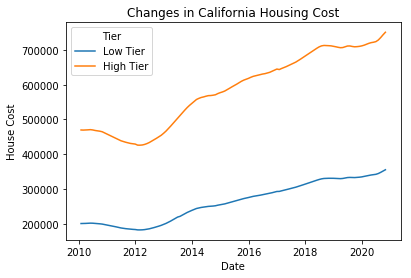

In [6]:
sns.lineplot(data=county_home_value_melt, x="Date", y="House Cost",hue="Tier",ci=None).set_title('Changes in California Housing Cost')


Text(0.5, 1.0, 'Changes in California Housing Cost (2020$))')

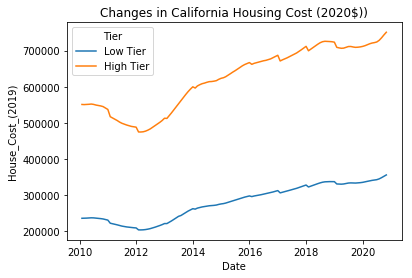

In [7]:
sns.lineplot(data=county_home_value_melt, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in California Housing Cost (2020$))')


###  Graph top 10 MSA 

In [8]:
#load in list of top 10 MSAs (file on github)
msa = pd.read_csv("/Users/quinnunderriner/Desktop/Work/missing_middle/msa.csv")
msa = msa[["MSA_NAME","COUNTIES"]]
top_10_msa = ['Riverside-San Bernardino-Ontario','San Jose-Sunnyvale-Santa Clara',
              'San Francisco-Redwood City-South San Francisco','Oakland-Hayward-Berkeley',
              'Los Angeles-Long Beach-Glendale','Anaheim-Santa Ana-Irvine','San Diego-Carlsbad',
               'Sacramento--Roseville--Arden-Arcade','Fresno','Oxnard-Thousand Oaks-Ventura']
msa = msa[msa.MSA_NAME.isin(top_10_msa)]
#need to expand mapping 
msa = msa.drop('COUNTIES', axis=1).join(
  msa['COUNTIES'].str.split(',', expand=True).stack()
    .reset_index(level=1,drop=True).rename('COUNTIES'))
msa['COUNTIES'] = msa['COUNTIES'] + " County" 
msa = msa.rename(columns={"COUNTIES":"County_Name","MSA_NAME":"Metro"})#rename for clean merge

# merge and subset data to just contain top 10 MSAs 
top_10_msa = msa.merge(county_home_value_melt, on="Metro",how="left")

Text(0.5, 1.0, 'Changes in Housing Cost California top 10 MSAs ($2020))')

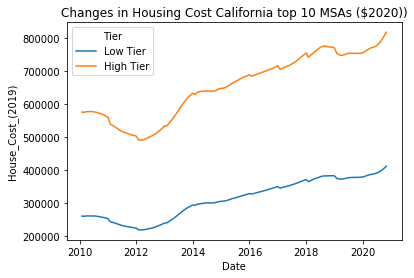

In [9]:
sns.lineplot(data=top_10_msa, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in Housing Cost California top 10 MSAs ($2020))')

### Graph Counties 

In [10]:
#make subsets with just LA and Lake counties for graphing 
lake_county_home_value_melt = county_home_value_melt[county_home_value_melt.RegionName=="Lake County"]
LA_county_home_value_melt = county_home_value_melt[county_home_value_melt.RegionName=="Los Angeles County"]

Text(0.5, 1.0, 'Changes in Housing Cost Los Angeles ($2020))')

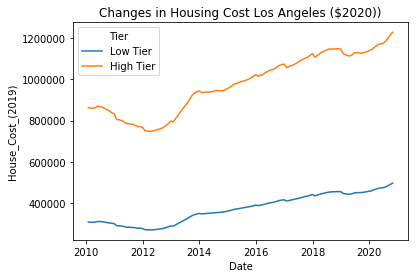

In [11]:
sns.lineplot(data=LA_county_home_value_melt, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in Housing Cost Los Angeles ($2020))')

Text(0.5, 1.0, 'Changes in Housing Cost Lake County ($2020))')

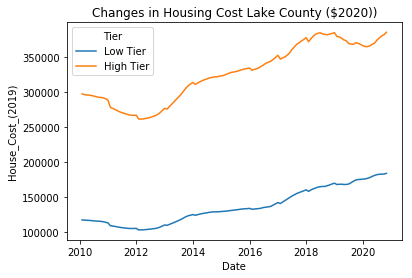

In [12]:
sns.lineplot(data=lake_county_home_value_melt, x="Date", y="House_Cost_(2019)",hue="Tier",ci=None).set_title('Changes in Housing Cost Lake County ($2020))')

### HMDA data 

hmda = pd.read_csv("2019_public_lar_csv.csv") #dont want to run this again because file so big, ~ 7GB
hmda_ca.to_csv("CA_only_2019_public_lar_csv.csv")
hmda_ca = pd.read_csv("hmda_ca")
filter for california
hmda_ca = hmda[hmda.state_code=="CA"]


data from here for 2019 https://ffiec.cfpb.gov/data-publication/snapshot-national-loan-level-dataset/2019
from here for 2010 https://www.consumerfinance.gov/data-research/hmda/historic-data/?geo=ca&records=originated-records&field_descriptions=labels

2019 data dictionary: https://ffiec.cfpb.gov/documentation/2019/lar-data-fields/
2010 data dictionary: https://files.consumerfinance.gov/hmda-historic-data-dictionaries/lar_record_codes.pdf

In [13]:
#read in 2019 data
hmda_ca_19 = pd.read_csv("CA_only_2019_public_lar_csv.csv")
#read in 2010 data 
hmda_ca_10 = pd.read_csv("hmda_2010_ca_originated-records_labels.csv")
#read in AMI bands 
county_level_AMI = pd.read_csv("year_county_AMI.csv")
county_level_AMI = county_level_AMI.rename(columns={"County_Name":"county_name"})

MSA_level_AMI = pd.read_csv("year_MSA_AMI.csv")

#FIPS codes. https://github.com/kjhealy/fips-codes 
county_fips = pd.read_csv("county_fips_master.csv", encoding='latin-1')
county_fips = county_fips[county_fips["state_abbr"]=="CA"]
county_fips = county_fips.rename(columns={"fips":"county_code"})

In [14]:
#filter data for correct years 
county_level_AMI_2010 = county_level_AMI[county_level_AMI.year == 2010]
county_level_AMI_2019 = county_level_AMI[county_level_AMI.year == 2019]

#### Want to filter data for owner occupied princple residences, home purchases (not refinance), and for first liens that are actually disbursed


In [15]:
#filter 2010 data 
#hmda_ca_10 = hmda_ca_10[hmda_ca_10.property_type == 1] #single family home 
hmda_ca_10 = hmda_ca_10[hmda_ca_10.owner_occupancy == 1] #owner occupied
hmda_ca_10 = hmda_ca_10[hmda_ca_10.loan_purpose == 1]#loan for home purchase 
hmda_ca_10 = hmda_ca_10[hmda_ca_10.action_taken == 1] #loan actually disbursed 
hmda_ca_10 = hmda_ca_10[hmda_ca_10.lien_status == 1] #1st lien 

In [16]:
#filter 2019 data 
hmda_ca_19 = hmda_ca_19[hmda_ca_19.derived_loan_product_type.isin(["Conventional:First Lien","FHA:First Lien",
                                           "VA:First Lien","FSA/RHS:First Lien"])] #first lien types 
hmda_ca_19 = hmda_ca_19[hmda_ca_19.business_or_commercial_purpose == 2] #Not primarily for a business or commercial purpose
hmda_ca_19 = hmda_ca_19[hmda_ca_19.loan_purpose == 1] #Home purchase
#hmda_ca_19 = hmda_ca_19[hmda_ca_19.derived_dwelling_category == "Single Family (1-4 Units):Site-Built"] #dwelling type 
hmda_ca_19 = hmda_ca_19[hmda_ca_19.occupancy_type == 1]  #Principal residence
hmda_ca_19 = hmda_ca_19[hmda_ca_19.action_taken == 1]  #loan actually originated 


In [17]:
#grab subset of cols 
hmda_ca_sub = hmda_ca_19[["loan_amount","property_value","income","county_code"]]
hmda_ca_10_sub = hmda_ca_10[["loan_amount_000s","applicant_income_000s","county_name","county_code"]]

#little data cleaning
hmda_ca_10_sub["loan_amount"] = hmda_ca_10_sub["loan_amount_000s"] *1000
hmda_ca_10_sub["applicant_income"] = hmda_ca_10_sub["applicant_income_000s"] *1000
hmda_ca_10_sub = hmda_ca_10_sub.drop(columns=["applicant_income_000s","loan_amount_000s"])
hmda_ca_sub["income"] = hmda_ca_sub["income"] *1000

In [18]:
#merge county name for 2019 data 
hmda_ca_sub = hmda_ca_sub.dropna()
hmda_ca_sub.county_code = hmda_ca_sub.county_code.astype(int)
hmda_ca_sub = hmda_ca_sub.merge(county_fips,on="county_code",how="left")

In [19]:
#merge on ami data for 2019 data
hmda_ca_sub = hmda_ca_sub.merge(county_level_AMI_2019,on="county_name",how="left")
#merge on ami data for 2010 data
hmda_ca_10_sub = hmda_ca_10_sub.merge(county_level_AMI_2010,on="county_name",how="left")


In [20]:
hmda_ca_sub['80-120%AMI_HH'] = np.where((hmda_ca_sub["income"] >= hmda_ca_sub["80%_AMI"])&(hmda_ca_sub["income"] <= hmda_ca_sub["120%_AMI"]), 1, 0)
hmda_ca_10_sub['80-120%AMI_HH'] = np.where((hmda_ca_10_sub["applicant_income"] >= hmda_ca_10_sub["80%_AMI"])&(hmda_ca_10_sub["applicant_income"] <= hmda_ca_10_sub["120%_AMI"]), 1, 0)

In [21]:
hmda_ca_sub["80-120%AMI_HH"].sum() / len(hmda_ca_sub["80-120%AMI_HH"])

0.23326862666657922

Percentage of loans for middle income buyers in california 2019: 23.1% 

In [22]:
hmda_ca_10_sub["80-120%AMI_HH"].sum() / len(hmda_ca_10_sub["80-120%AMI_HH"])

0.26317900505680947

Percentage of loans for middle income buyers in california 2010: 26.3%

In [23]:
#grab only middle income households 
hmda_ca_sub_mid = hmda_ca_sub[hmda_ca_sub["80-120%AMI_HH"]==1]
hmda_ca_10_sub_mid = hmda_ca_10_sub[hmda_ca_10_sub["80-120%AMI_HH"]==1]

In [24]:
hmda_ca_sub_mid.loan_amount.mean()

357947.32846961584

In [25]:
hmda_ca_10_sub_mid.loan_amount.mean()

261217.6959890611

There has also been an increase in the average cost of these loans: 311,620 in 2010 (262,527 in 2010 dollars, adjusted here to 2019 dollars) 362,875 in 2019 (a CPI adjusted 16.4% increase). 

In [27]:
#make a dataframe that shows, in absolute numbers, the changes between number of middle income households that bought houses by county
changed_by_location=pd.DataFrame(hmda_ca_sub_mid.groupby("county_name").size() - hmda_ca_10_sub_mid.groupby("county_name").size())
changed_by_location = changed_by_location.reset_index().rename(columns={0:"Change in Number of Middle Income Home Buyers"}).drop([10,28])
#drop madera and shasta as tehre is no 2010 AMI data for them 
changed_by_location = changed_by_location.rename(columns={"county_name":"County Name"})
#changed_by_location = changed_by_location.drop(['index'], axis=1)


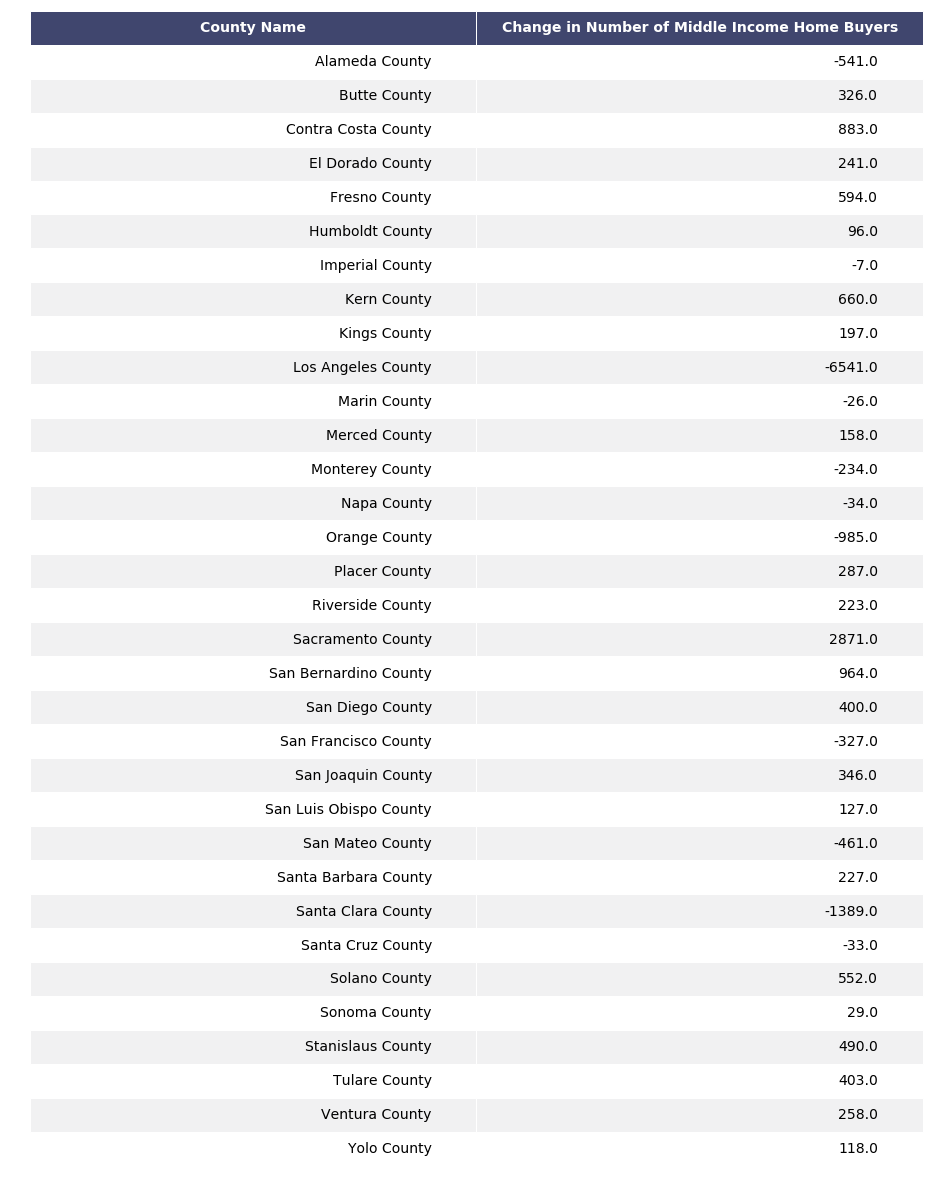

In [28]:
#function to make dataframe print prettier
#https://stackoverflow.com/questions/26678467/export-a-pandas-dataframe-as-a-table-image
def render_mpl_table(data, col_width=14.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

render_mpl_table(changed_by_location, header_columns=0, col_width=8.0)

#### Now, want to calculate how much home a middle income invidividual could afford

Used this for interests rates http://www.freddiemac.com/pmms/pmms30.html
3.94 average interest rate in 2019
4.69 avearge interest rate in 2010 

These are monthly 

In [29]:
IR_2019 = 3.94
IR_2010 = 4.69

https://www.nar.realtor/research-and-statistics/housing-statistics/housing-affordability-index/methodology

Note: Here the equation is for the monthly cost of the loan, assuming 20% down. So the calculate below multiplies by 12*30 (12 months, 30 year mortgate) to back out the total cost with these monthy costs. But because we are assumign out the 20% down payment, the actual home value is 25% more. However, in the HDMA loan data we are seeing value of the loans, not total value of house
so do NOT need to add down payment back in when calculating how many of the loans in the HMDA data would have been 
affordable, but important to note if we want to talk about cost of loan one can afford VS. value of house one can afford. 
    
I am calculating total loan cost by taking 30% of the monthly wage (the "affordable amount") and then multiplied over the normal life of a loan 30 years (30*12). 

In [30]:
#below should be complete and returns value of total loan someone at a given income, x, could afford. 
def calc_house_afford(x,interest_2010=True):
    if interest_2010 == True:
        interest = 4.69
    if interest_2010 == False:
        #this is the 2019 rate 
        interest = 3.94

    #need to add a line that checks weather data is 2010 or 2019 for
    #which interest rate to use, or seperate dataframes and concat back together
    monthly_wage = x/12 #yearly wage / 12 
    N = (30*12) #assuming a 30 year mortgage 
    r = (interest /100)/12 #monthly interest rate, IR_2010 is for 2010 data. Divide by 100 to get 3.94 to 0.0394
    denom = 1 - (1 + r)**-N 
    P = (denom * .3 * monthly_wage)/r
    return P

did some validation checks with zillow tool https://www.zillow.com/mortgage-calculator/house-affordability/
and figures seem reeasonable 

In [31]:
calc_house_afford(93000)#value of loan, multiple by 25% to get house value 

448809.7051041187

In [ ]:
(len(hmda_ca_sub) - len(hmda_ca_10_sub))/len(hmda_ca_10_sub)
#14 percent more overall loans in 2019 than 2010, so initially want to compare percentages between 2010 and 2019, 
#not absolute values 

In [48]:
#create 100% AMI columns from 80% columns 
hmda_ca_10_sub["100% AMI"] = hmda_ca_10_sub["80%_AMI"] * 1.25
hmda_ca_sub["100% AMI"] = hmda_ca_sub["80%_AMI"] * 1.25
#clean up names 
hmda_ca_10_sub = hmda_ca_10_sub.rename(columns={"80%_AMI":"80% AMI"})
hmda_ca_sub = hmda_ca_sub.rename(columns={"80%_AMI":"80% AMI"})

In [33]:
def calc_loan_values_2019(x):
    return calc_house_afford(x,interest_2010=False)
def calc_loan_values(x):
    return calc_house_afford(x)

#col = "120%_AMI"
def calc_value(df,col, year):
    """
    inputs:
        df with county name, income for AMI band
        col: string, name of AMI band we are calculating value for 
        year: int, in this case either 2010 or 2019. Makes sure we use interest rates for year we are trying to calculate for 
    Below I am calculating the max affordable loan amount for a XXX AMI household and then 
    calculating, for each county, what percentage of all loans fall below that threshold  
     
    """
    if col not in df:
        print("Column not in dataframe")
    
    max_afford_str = "Max_Affordable_Loan_" + col
    is_affordable_str = "Is_Afforable_120%AMI" + col
    
    if year == 2019:
        df[max_afford_str]= df[col].apply(lambda x: calc_loan_values_2019(x))
    elif year == 2010:
        df[max_afford_str]= df[col].apply(lambda x: calc_loan_values(x))
    else:
        print("Invalid Year")
    df[is_affordable_str] = np.where(df[max_afford_str] >= df["loan_amount"], 1, 0)

    total_affordable= df[["county_name",is_affordable_str]].groupby("county_name").sum().reset_index() #get sum of affordable loans
    total_affordable = total_affordable[(total_affordable != 0).all(1)]#drop zero columns; here they are just <75k population counties 
    #unlike in other analysis, merging them all together into "multiple counties" doesn't seem illustritive or useful here 
    #get total number of loans
    total=hmda_ca_sub[["county_name",is_affordable_str]].groupby("county_name").size().reset_index()
    #note could be worth also looking at absolute value here 

    #merge two data set together 
    affordable = total.merge(total_affordable,on="county_name")
    #creat new col
    new_col = "Percent of Loans Affordable to " + col + " or Lower Households " + str(year)
    
    affordable[new_col] = affordable[is_affordable_str] / affordable[0]
    #only keep cols we need 
    affordable = affordable[["county_name",new_col]]
    return affordable

def merge_years(df2010,df2019):
    """
    After doing Max Loan value calculations for each 2010 and 2019 above, 
    this little function just merges these columns together, keeps only the cols we want
    and then calcualtes the percentage change in percentage of affordable loans in 2010 and 2019
    """
    affordable_2010_2019 = df2019.merge(df2010,on="county_name")
    col_2019 = [i for i in affordable_2010_2019.columns.tolist() if "Households 2019" in i]
    col_2010 = [i for i in affordable_2010_2019.columns.tolist() if "Households 2010" in i] 
    affordable_2010_2019["Percent Change"] = ((affordable_2010_2019[col_2019[0]] - affordable_2010_2019[col_2010[0]])/affordable_2010_2019[col_2010[0]])*100
    affordable_2010_2019 = affordable_2010_2019.sort_values("Percent Change")
    affordable_2010_2019 = affordable_2010_2019.rename(columns={"county_name":"County Name"})
    return affordable_2010_2019

In [44]:
#run the above funcitons for 
#120% AMI 
affodable_2019_120AMI=calc_value(hmda_ca_sub,"120%_AMI", 2019)
affodable_2010_120AMI=calc_value(hmda_ca_10_sub,"120%_AMI", 2010)
affodable_2010_to_2019_120AMI = merge_years(affodable_2010_120AMI,affodable_2019_120AMI)
#100% AMI 
affodable_2019_100AMI=calc_value(hmda_ca_sub,"100% AMI", 2019)
affodable_2010_100AMI=calc_value(hmda_ca_10_sub,"100% AMI", 2010)
affodable_2010_to_2019_100AMI = merge_years(affodable_2010_100AMI,affodable_2019_100AMI)
#80% AMI 
affodable_2019_80AMI=calc_value(hmda_ca_sub,"80% AMI", 2019)
affodable_2010_80AMI=calc_value(hmda_ca_10_sub,"80% AMI", 2010)
affodable_2010_to_2019_80AMI = merge_years(affodable_2010_80AMI,affodable_2019_80AMI)

In [39]:
#set theme for altair plotting 
def terner_theme():
    # Typography
    font = "Veranda Regular"
    labelFont = "Veranda Regular" 
    sourceFont = "Veranda Regular"
    # Colors
    main_palette = ["#4E748B"]
    return{"config": {
              "title": {
                  "font": font,
              },
              
              "range": {
                  "category": main_palette,

              
            },
                      "legend": {
                  "labelFont": labelFont,
                      },
           "bar": {   
                "fill": main_palette,
                "stroke": False,
            },
}
    }

# register
alt.themes.register("terner_theme", terner_theme)
# enable
alt.themes.enable("terner_theme")

ThemeRegistry.enable('terner_theme')

In [40]:
alt.Chart(affodable_2010_to_2019_120AMI).mark_bar().encode(
    x='County Name',
    y='Percent Change',
    tooltip=['Percent Change']
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percent Change in Loans Affordable to 120% AMI or Lower Households in California 2010-2019"]})

alt.Chart(...)

In [53]:
alt.Chart(affodable_2010_to_2019_100AMI).mark_bar().encode(
    x='County Name',
    y='Percent Change',
    tooltip=['Percent Change']
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percent Change in Loans Affordable to 100% AMI or Lower Households in California 2010-2019"]})

alt.Chart(...)

In [57]:
alt.Chart(affodable_2010_to_2019_80AMI).mark_bar().encode(
    x='County Name',
    y='Percent Change',
    tooltip=['Percent Change']
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percent Change in Loans Affordable to 80% AMI or Lower Households in California 2010-2019"]})

alt.Chart(...)

Now do the same graphs for the top 10 MSAs 

In [58]:
#bring in csv mapping county names to the top 10 largest MSAs in california 
msa_county_map = pd.read_csv("msa_county_map.csv")
msa_county_map = msa_county_map.rename(columns={"County_Name":"County Name","MSA_NAME":"MSA"})

#merge this onto the 120, 100 and 80 dataframes 

msa_county_mapAMI = msa_county_map.merge(affodable_2010_to_2019_120AMI,on="County Name")
msa_county_mapAMI100 = msa_county_map.merge(affodable_2010_to_2019_100AMI,on="County Name")
msa_county_mapAMI80 = msa_county_map.merge(affodable_2010_to_2019_80AMI,on="County Name")

In [62]:
alt.Chart(msa_county_mapAMI).mark_bar().encode(
    x='MSA',
    y='Percent Change',
    tooltip=['Percent Change']
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percent Change in Loans Affordable to 120% AMI or Lower Households in California 2010-2019"]})

alt.Chart(...)

In [63]:
alt.Chart(msa_county_mapAMI100).mark_bar().encode(
    x='MSA',
    y='Percent Change',
    tooltip=['Percent Change']
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percent Change in Loans Affordable to 100% AMI or Lower Households in California 2010-2019"]})

alt.Chart(...)

In [64]:
alt.Chart(msa_county_mapAMI80).mark_bar().encode(
    x='MSA',
    y='Percent Change',
    tooltip=['Percent Change']
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percent Change in Loans Affordable to 80% AMI or Lower Households in California 2010-2019"]})

alt.Chart(...)

Now to add three charts with percentages of the total loans for 2019 only that are affordable to 120, 100 and 80AMI groups, respectively. 

In [42]:
affodable_2010_to_2019_120AMI = affodable_2010_to_2019_120AMI.rename(columns={"Percent of Loans Affordable to 120%_AMI or Lower Households 2019":"Percent"})

alt.Chart(affodable_2010_to_2019_120AMI).mark_bar().encode(
    alt.Y('Percent',scale=alt.Scale(domain=(0,1))),
    x ='County Name',
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percentage of Total Loans Affordable to 120% AMI or Lower Households in California 2019"]})

alt.Chart(...)

In [50]:
affodable_2010_to_2019_100AMI = affodable_2010_to_2019_100AMI.rename(columns={"Percent of Loans Affordable to 100% AMI or Lower Households 2019":"Percent"})
alt.Chart(affodable_2010_to_2019_100AMI).mark_bar().encode(
    alt.Y('Percent',scale=alt.Scale(domain=(0,1))),
    x ='County Name',
    
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percentage of Total Loans Affordable to 100% AMI or Lower Households in California 2019"]})

alt.Chart(...)

In [66]:
affodable_2010_to_2019_80AMI = affodable_2010_to_2019_80AMI.rename(columns={"Percent of Loans Affordable to 80% AMI or Lower Households 2019":"Percent"})

alt.Chart(affodable_2010_to_2019_80AMI).mark_bar().encode(
    alt.Y('Percent',scale=alt.Scale(domain=(0,1))),
    x ='County Name',
).configure(background="#ffffff").configure_legend().properties(
    title={
      "text": ["Percentage of Total Loans Affordable to 80% AMI or Lower Households in California 2019"]})

alt.Chart(...)